# TITANIC

Features

###### pclass = Ticket class
###### sibsp = # of siblings / spouses aboard the Titanic
###### parch = # of parents / children aboard the Titanic
###### ticket = Ticket number
###### fare = Passenger Tarifa
###### cabin = Cabin number
###### embarked = Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)

In [149]:
import kaggle
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, accuracy_score)
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [150]:
#kaggle competitions download -c titanic

In [151]:
#Importar las bases
test = pd.read_csv('C:/Users/jonny/Documents/01_Jonny/Kaggle/titanic/test.csv', delimiter = ',', decimal='.')
base = pd.read_csv('C:/Users/jonny/Documents/01_Jonny/Kaggle/titanic/train.csv', delimiter = ',', decimal='.')

In [152]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [153]:
base.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [154]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [155]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Faltantes

<AxesSubplot:>

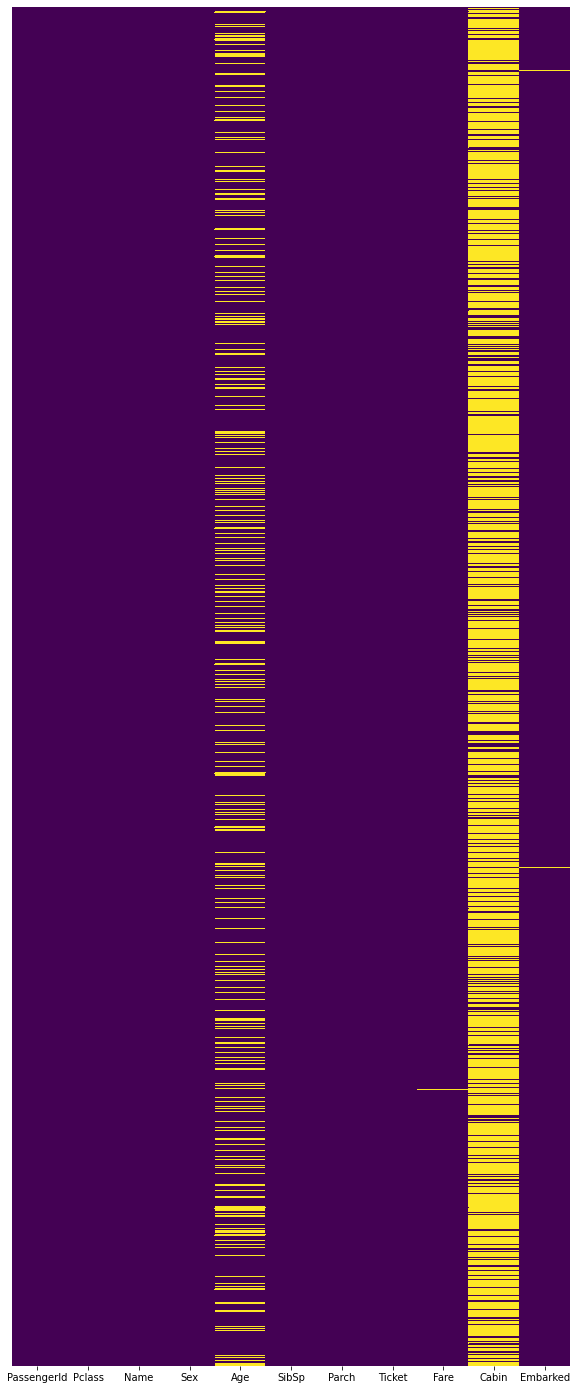

In [156]:
combined = pd.concat([base.drop('Survived',axis=1),test])
plt.figure(figsize=(10,25))
sns.heatmap(combined.isnull(),cmap="viridis",yticklabels=False,cbar=False)

In [157]:
# revisar faltantes base
base.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [158]:
# revisar faltantes test
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [159]:
#Imputar Faltantes en el campo Edad
print(base['Age'].mean())
print(test['Age'].mean())

29.69911764705882
30.272590361445783


In [160]:
#Imputar los NaN en Edad por promedio
promedio = 30
base['Age'] = base['Age'].replace(np.nan, promedio)
test['Age'] = test['Age'].replace(np.nan, promedio)

In [161]:
#Imputar Faktantes en Fare con la media
print(test['Fare'].mean())

35.6271884892086


In [162]:
#Reemplazar los NaN en Fare por promedio
promedio_Fare = 35
test['Fare'] = test['Fare'].replace(np.nan, promedio_Fare)

In [163]:
#Eliminar Cabin porque tiene muchos vacios
base = base.drop('Cabin', axis = 1)
test = test.drop('Cabin', axis = 1)

In [164]:
#Eliminar Filas con faltantes en base porque son pocas
base.dropna(axis = 0, how = 'any', inplace = True)

In [165]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


## Ingeniería de variables

In [166]:
#Crear Rangos de Edad
bins = [0, 12, 20, 30, 40, 140]
names = ["Niño","Adolescente","Joven","Maduro","Mayor 40"]
base['Rango_Edad'] = pd.cut(base['Age'], bins,labels = names)
test['Rango_Edad'] = pd.cut(test['Age'], bins,labels = names)

In [167]:
df_p = base.groupby(['Rango_Edad'])['Age'].count()
df_p

Rango_Edad
Niño            69
Adolescente    110
Joven          407
Maduro         154
Mayor 40       149
Name: Age, dtype: int64

In [168]:
#Crear Rangos de Tarifa
bins = [0, 7.91, 14.45, 31, 540]
names = ["Low_Fare","Median_Fare","Average_Fare","High_fare"]
base['Rango_Fare'] = pd.cut(base['Fare'], bins,labels = names)
test['Rango_Fare'] = pd.cut(test['Fare'], bins,labels = names)

In [169]:
df_p = base.groupby(['Rango_Fare'])['Fare'].count()
df_p

Rango_Fare
Low_Fare        208
Median_Fare     217
Average_Fare    229
High_fare       220
Name: Fare, dtype: int64

In [170]:
# Crear la variable tamaño de la familia
base['FamilySize'] = base['SibSp'] + base['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [171]:
all_data=[base,test]

In [172]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [173]:
#Eliminar Cabin, Id, Name y Ticket
base = base.drop(['PassengerId','Name', 'Ticket', 'Age', 'Fare'], axis = 1)
test = test.drop(['Name', 'Ticket','Age', 'Fare'], axis = 1)

In [174]:
base.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title
0,0,3,male,1,0,S,Joven,Low_Fare,2,Mr
1,1,1,female,1,0,C,Maduro,High_fare,2,Mrs
2,1,3,female,0,0,S,Joven,Median_Fare,1,Miss


In [175]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    889 non-null    int64   
 1   Pclass      889 non-null    int64   
 2   Sex         889 non-null    object  
 3   SibSp       889 non-null    int64   
 4   Parch       889 non-null    int64   
 5   Embarked    889 non-null    object  
 6   Rango_Edad  889 non-null    category
 7   Rango_Fare  874 non-null    category
 8   FamilySize  889 non-null    int64   
 9   Title       889 non-null    object  
dtypes: category(2), int64(5), object(3)
memory usage: 64.6+ KB


In [176]:
base.shape

(889, 10)

## Análisis Descriptivo

IndexError: index 7 is out of bounds for axis 0 with size 6

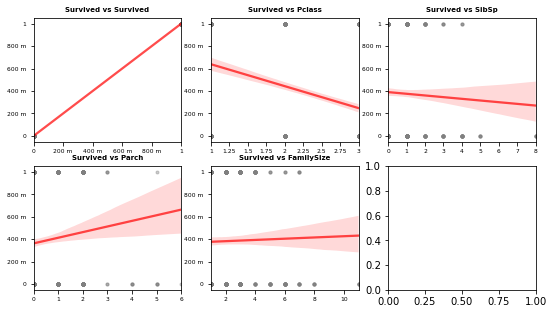

In [177]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = base.select_dtypes(include=['float64', 'int64', 'int32']).columns
#columnas_numeric = columnas_numeric.drop('Survived')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = base[colum],
        y           = base['Survived'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"Survived vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [7]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con Survived', fontsize = 10, fontweight = "bold");

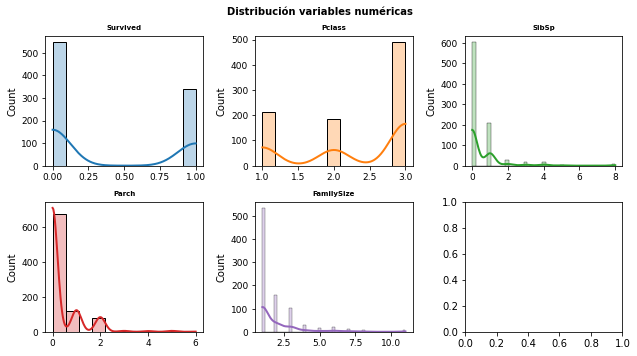

In [178]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = base.select_dtypes(include=['float64', 'int64','int32']).columns
#columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = base,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [180]:
columnas_numericas = base.select_dtypes(include=['float64', 'int64', 'int32']).columns

In [181]:
columnas_numericas

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'FamilySize'], dtype='object')

<function matplotlib.pyplot.show(close=None, block=None)>

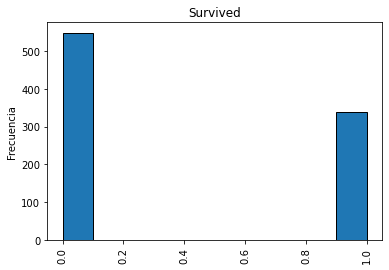

In [182]:
i = 'Survived'
plt.hist(base[i], bins=10, edgecolor='black')
plt.title(i)
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.show

In [183]:
base.select_dtypes(include=['float64', 'int64', 'int32']).describe()

,Survived,Pclass,SibSp,Parch,FamilySize
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.524184,0.382452,1.906637
std,0.486260,0.834700,1.103705,0.806761,1.614703
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,0.000000,2.000000
max,1.000000,3.000000,8.000000,6.000000,11.000000


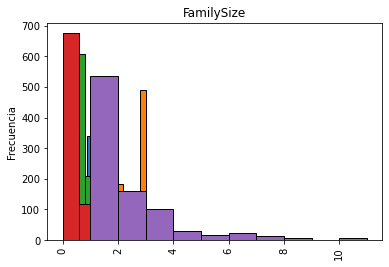

In [184]:
#Histogramas
for i in columnas_numericas:
    plt.hist(base[i], bins=10, edgecolor='black')
    plt.title(i)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=90)
    plt.show

### Variables Categoricas

In [185]:
base.select_dtypes(include=['object','category']).describe()

,Sex,Embarked,Rango_Edad,Rango_Fare,Title
count,889,889,889,874,889
unique,2,3,5,4,5
top,male,S,Joven,Average_Fare,Mr
freq,577,644,407,229,517


In [186]:
columnas_categoricas = base.select_dtypes(include=['object','category']).columns

In [187]:
columnas_categoricas

Index(['Sex', 'Embarked', 'Rango_Edad', 'Rango_Fare', 'Title'], dtype='object')

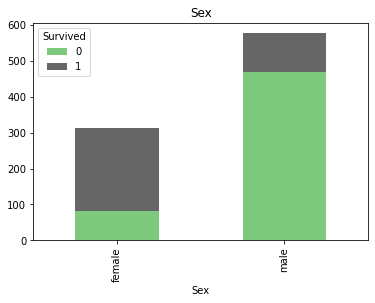

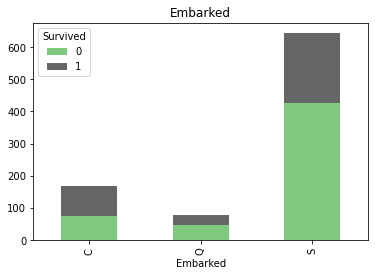

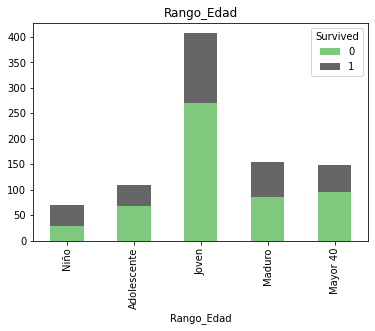

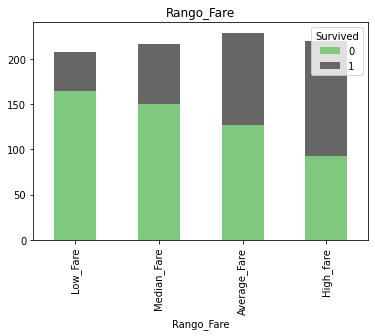

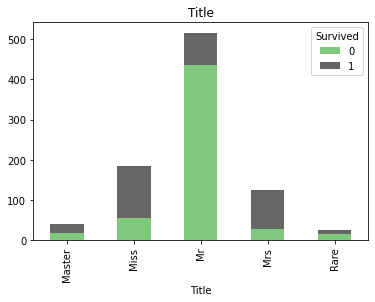

In [188]:
for i in columnas_categoricas:
    df2 = base.groupby(['Survived', i])['Survived'].count().unstack('Survived').fillna(0)
    #df2.sort_values('Loss', inplace=True,ascending=False)
    df2[[0,1]].plot(kind='bar', stacked=True, colormap = 'Accent')
    plt.title(str(i))

<AxesSubplot:xlabel='Title'>

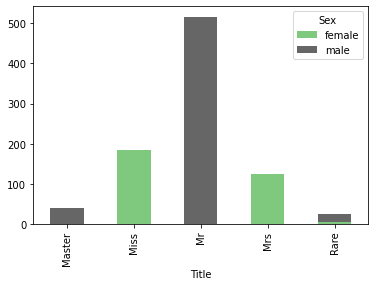

In [189]:

df2 = base.groupby(['Sex', 'Title'])['Sex'].count().unstack('Sex').fillna(0)
df2.plot(kind='bar', stacked=True, colormap = 'Accent')

In [190]:
x_num = base[columnas_numericas]

In [191]:
x_num.dtypes

Survived      int64
Pclass        int64
SibSp         int64
Parch         int64
FamilySize    int64
dtype: object

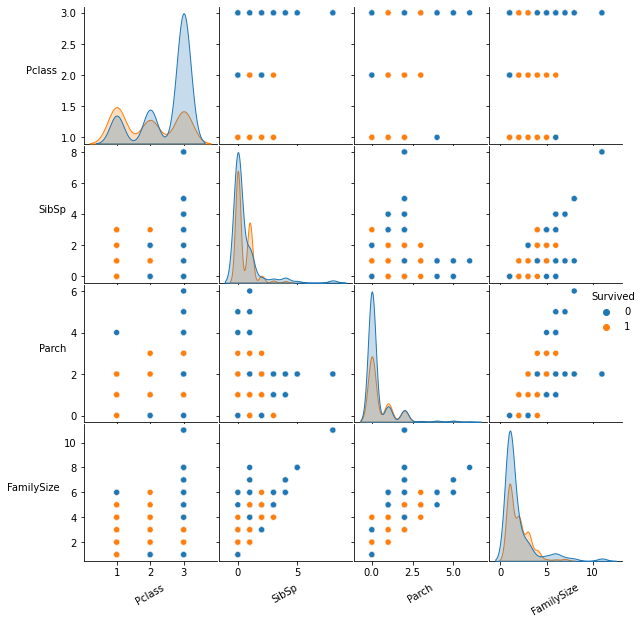

In [192]:
np.seterr(divide='ignore', invalid='ignore')
g = sb.pairplot(x_num, hue="Survived",height=8, aspect=1)
g.fig.set_size_inches(8,8)
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 30)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

Text(0.5, 1.0, 'Matriz de correlación')

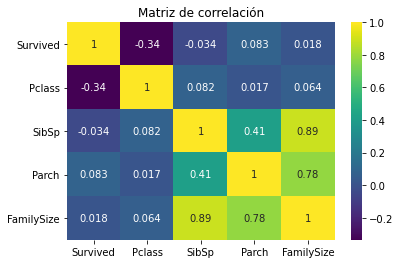

In [193]:
corrs = x_num.corr()
#mask = np.zeros_like(corrs)
#mask[np.triu_indices_from(mask)] = True
sb.heatmap(corrs, annot = True, cmap='viridis')
#cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4
plt.title('Matriz de correlación')

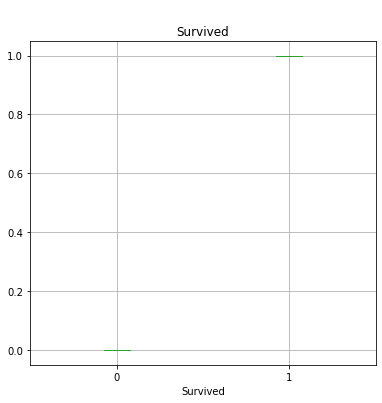

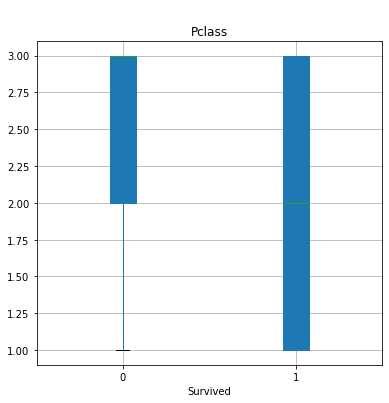

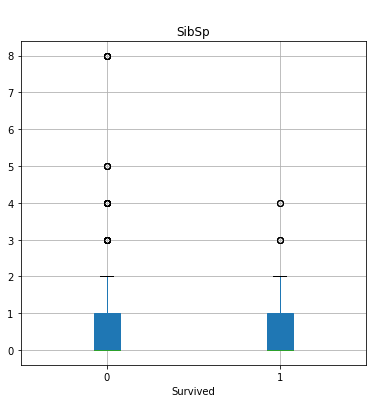

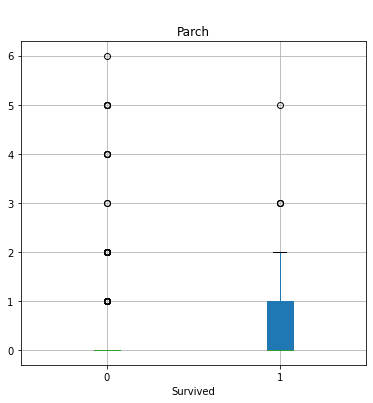

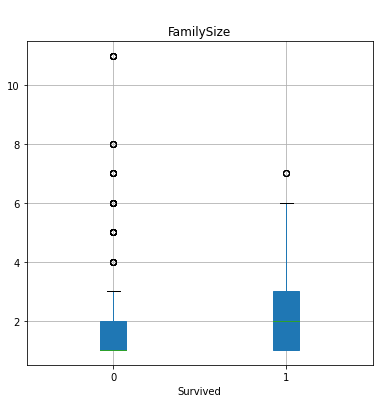

In [194]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
for i in columnas_numericas:
    base.boxplot(column = i, by = 'Survived', patch_artist = True, return_type='axes', figsize= [6,6] )
    plt.suptitle(str(i))
    plt.suptitle(" ")

In [195]:
test.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title
0,892,3,male,0,0,Q,Maduro,Low_Fare,1,Mr
1,893,3,female,1,0,S,Mayor 40,Low_Fare,2,Mrs


In [196]:
base.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title
0,0,3,male,1,0,S,Joven,Low_Fare,2,Mr
1,1,1,female,1,0,C,Maduro,High_fare,2,Mrs


In [197]:
#Crear Y y x_d

y = base["Survived"]
x_d = base.drop("Survived", axis=1)

#Convierte en un array
y = np.ravel(y)

In [198]:
x_d_test = test.drop("PassengerId",axis=1)

In [199]:
x_d.head(2)

,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title
0,3,male,1,0,S,Joven,Low_Fare,2,Mr
1,1,female,1,0,C,Maduro,High_fare,2,Mrs


In [200]:
x_d_test.head(2)

,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title
0,3,male,0,0,Q,Maduro,Low_Fare,1,Mr
1,3,female,1,0,S,Mayor 40,Low_Fare,2,Mrs


In [201]:
x = pd.get_dummies(x_d, columns = ["Sex","Title","Rango_Edad","Embarked","Rango_Fare"],
                             prefix=["Sex","Title","Rango_Edad","Embarked","Rango_Fare"])

In [202]:
x_test = pd.get_dummies(x_d_test, columns = ["Sex","Title","Rango_Edad","Embarked","Rango_Fare"],
                             prefix=["Sex","Title","Rango_Edad","Embarked","Rango_Fare"])

In [203]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Pclass                   889 non-null    int64
 1   SibSp                    889 non-null    int64
 2   Parch                    889 non-null    int64
 3   FamilySize               889 non-null    int64
 4   Sex_female               889 non-null    uint8
 5   Sex_male                 889 non-null    uint8
 6   Title_Master             889 non-null    uint8
 7   Title_Miss               889 non-null    uint8
 8   Title_Mr                 889 non-null    uint8
 9   Title_Mrs                889 non-null    uint8
 10  Title_Rare               889 non-null    uint8
 11  Rango_Edad_Niño          889 non-null    uint8
 12  Rango_Edad_Adolescente   889 non-null    uint8
 13  Rango_Edad_Joven         889 non-null    uint8
 14  Rango_Edad_Maduro        889 non-null    uint8
 15  Rango_

### Transformers

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.

numeric_cols = x_d.select_dtypes(include=['float64', 'int64', 'int32']).columns.to_list()
cat_cols = x_d.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'), cat_cols)])

In [58]:
X_train_prep = preprocessor.fit_transform(x_d)

In [59]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
x = preprocessor.transform(x_d)
x = pd.DataFrame(x, columns=labels)

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pclass                  889 non-null    float64
 1   SibSp                   889 non-null    float64
 2   Parch                   889 non-null    float64
 3   FamilySize              889 non-null    float64
 4   Sex_male                889 non-null    float64
 5   Embarked_Q              889 non-null    float64
 6   Embarked_S              889 non-null    float64
 7   Rango_Edad_Joven        889 non-null    float64
 8   Rango_Edad_Maduro       889 non-null    float64
 9   Rango_Edad_Mayor 40     889 non-null    float64
 10  Rango_Edad_Niño         889 non-null    float64
 11  Rango_Fare_High_fare    889 non-null    float64
 12  Rango_Fare_Low_Fare     889 non-null    float64
 13  Rango_Fare_Median_Fare  889 non-null    float64
 14  Rango_Fare_nan          889 non-null    fl

In [61]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
x_test = preprocessor.transform(x_d_test)
x_test = pd.DataFrame(x_test, columns=labels)

x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pclass                  418 non-null    float64
 1   SibSp                   418 non-null    float64
 2   Parch                   418 non-null    float64
 3   FamilySize              418 non-null    float64
 4   Sex_male                418 non-null    float64
 5   Embarked_Q              418 non-null    float64
 6   Embarked_S              418 non-null    float64
 7   Rango_Edad_Joven        418 non-null    float64
 8   Rango_Edad_Maduro       418 non-null    float64
 9   Rango_Edad_Mayor 40     418 non-null    float64
 10  Rango_Edad_Niño         418 non-null    float64
 11  Rango_Fare_High_fare    418 non-null    float64
 12  Rango_Fare_Low_Fare     418 non-null    float64
 13  Rango_Fare_Median_Fare  418 non-null    float64
 14  Rango_Fare_nan          418 non-null    fl

## Train y test

In [206]:
x.head(2)

,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Rango_Edad_Joven,Rango_Edad_Maduro,Rango_Edad_Mayor 40,Embarked_C,Embarked_Q,Embarked_S,Rango_Fare_Low_Fare,Rango_Fare_Median_Fare,Rango_Fare_Average_Fare,Rango_Fare_High_fare
0,3,1,0,2,0,1,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1,1,1,0,2,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1


In [207]:
x_test.head(2)

,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Rango_Edad_Joven,Rango_Edad_Maduro,Rango_Edad_Mayor 40,Embarked_C,Embarked_Q,Embarked_S,Rango_Fare_Low_Fare,Rango_Fare_Median_Fare,Rango_Fare_Average_Fare,Rango_Fare_High_fare
0,3,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,0
1,3,1,0,2,1,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0


In [208]:
#Divido la base de datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(711, 23) (178, 23) (711,) (178,)


In [209]:
z=list(y_train)
a = z.count(1)
b = z.count(0)

p = list(y_test)
q = p.count(1)
r = p.count(0)


print ('1= '+ str(a), '0= '+ str(b), '% train: '+ str(a/(a+b)))
print ('1= '+ str(q), '0= '+ str(r), '% test: '+ str(q/(q+r)))


1= 271 0= 440 % train: 0.38115330520393814
1= 69 0= 109 % test: 0.38764044943820225


In [211]:
x.head(2)

,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Rango_Edad_Joven,Rango_Edad_Maduro,Rango_Edad_Mayor 40,Embarked_C,Embarked_Q,Embarked_S,Rango_Fare_Low_Fare,Rango_Fare_Median_Fare,Rango_Fare_Average_Fare,Rango_Fare_High_fare
0,3,1,0,2,0,1,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
1,1,1,0,2,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1


### Support Vector Machine

In [247]:
svc = SVC(C = 1000, gamma = 0.001, kernel = 'rbf')

In [248]:
svc.fit(X_train, y_train)

SVC(C=1000, gamma=0.001)

In [249]:
Y_pred = svc.predict(X_train)
print("Precision Maquinas de soporte Vectorial:")
print(svc.score(X_train, y_train))

Precision Maquinas de soporte Vectorial:
0.8340365682137834


In [84]:
# grid search maquinas de soporte vectorial
'''
param_grid = {'C': [0.1, 1, 10, 50, 100, 200, 300, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 
  
grid = GridSearchCV(SVC(), param_grid, cv = 5, scoring = "accuracy", n_jobs =4, verbose = 1)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
'''

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.8270067960208806


In [252]:
y_pred_train_svc =svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)

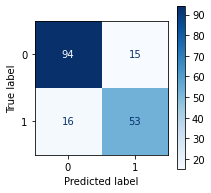

Accuracy SVM Test 0.8258426966292135
Sensibility SVM Test 0.7681159420289855
Specificity SVM Test 0.8623853211009175


In [253]:
### Metricas SVM TEST

fig, ax = plt.subplots (figsize = (3, 3))
cm_svc = metrics.confusion_matrix(y_test,y_pred_test_svc)
disp_xsvc=ConfusionMatrixDisplay(cm_svc,display_labels=[0,1])
disp_xsvc = disp_xsvc.plot(cmap=plt.cm.Blues,values_format='g', ax = ax)
plt.show()
print('Accuracy SVM Test',metrics.accuracy_score(y_test,y_pred_test_svc))
print('Sensibility SVM Test',metrics.recall_score( y_test,y_pred_test_svc,pos_label=1))
print('Specificity SVM Test',metrics.recall_score( y_test,y_pred_test_svc,pos_label=0))

In [254]:
test['Survived'] = (svc.predict(x_test))

In [255]:
gender_submission = test.iloc[:, [0,10]]

In [257]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [258]:
gender_submission.to_csv('gender_submission_svm.csv',index=False)

### Random Forest

In [262]:
# Gridsearch Random Forest1

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [263]:
#GridSearch Random Forest2

#Cross Validation
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                                n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
clf_random.fit(X_train, y_train)
clf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'n_estimators': 800,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [88]:
'''
{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}
 '''

In [267]:
clf = RandomForestClassifier(bootstrap= True, n_estimators=800,
                             max_features='auto', max_depth= None, random_state=1, n_jobs=1, 
                             min_samples_split= 10, min_samples_leaf= 1, criterion='gini', 
                             verbose = 0, oob_score =False, warm_start=False, class_weight =None)

cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean()

0.8213419405320813

In [225]:
clf.fit(X_train, y_train)
y_pred_clf = clf.predict_proba(X_test)
y_pred_train_clf=(clf.predict_proba(X_train)[:,1] >= 0.45).astype(float)
y_pred_test_clf = (clf.predict_proba(X_test)[:,1] >= 0.45).astype(float)

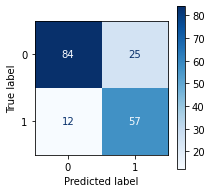

Accuracy RF Test 0.7921348314606742
Sensibility RF Test 0.8260869565217391
Specificity RF Test 0.7706422018348624


In [226]:
### Metricas Random Forest TEST

fig, ax = plt.subplots (figsize = (3, 3))
cm_clf = metrics.confusion_matrix(y_test,y_pred_test_clf)
disp_xclf=ConfusionMatrixDisplay(cm_clf,display_labels=[0,1])
disp_xclf = disp_xclf.plot(cmap=plt.cm.Blues,values_format='g', ax = ax)
plt.show()
print('Accuracy RF Test',metrics.accuracy_score(y_test,y_pred_test_clf))
print('Sensibility RF Test',metrics.recall_score( y_test,y_pred_test_clf,pos_label=1))
print('Specificity RF Test',metrics.recall_score( y_test,y_pred_test_clf,pos_label=0))

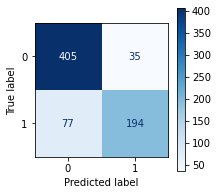

Accuracy RF Train 0.8424753867791842
Sensibility RF Train 0.7158671586715867
Specificity RF Train 0.9204545454545454


In [428]:
### Metricas para Random Forest TRAIN

fig, ax = plt.subplots (figsize = (3, 3))
cm_clf_train = metrics.confusion_matrix(y_train,y_pred_train_clf)
disp_xclf=ConfusionMatrixDisplay(cm_clf_train,display_labels=[0,1])
disp_xclf = disp_xclf.plot(cmap=plt.cm.Blues,values_format='g', ax = ax)
plt.show()
print('Accuracy RF Train',metrics.accuracy_score(y_train,y_pred_train_clf))
print('Sensibility RF Train',metrics.recall_score( y_train,y_pred_train_clf,pos_label=1))
print('Specificity RF Train',metrics.recall_score( y_train,y_pred_train_clf,pos_label=0))

Important features
____________________________________________________________
84.67


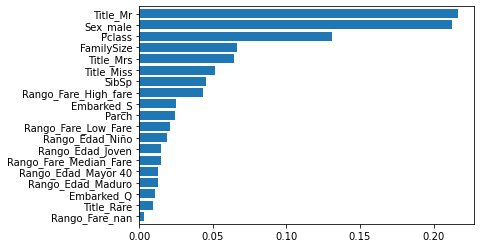

In [142]:
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print("Important features")
pd.Series(clf.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

In [143]:
test['Survived'] = (clf.predict_proba(x_test)[:,1] >= 0.45).astype(int)

In [144]:
test.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Rango_Edad,Rango_Fare,FamilySize,Title,Survived
0,892,3,male,0,0,Q,Maduro,Low_Fare,1,Mr,0
1,893,3,female,1,0,S,Mayor 40,Low_Fare,2,Mrs,1


In [145]:
gender_submission = test.iloc[:, [0,10]]

In [146]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [147]:
gender_submission.to_csv('gender_submission_RF.csv',index=False)

### XGBOOST

In [106]:
# XGBoost
xgb1 = xgb.XGBClassifier(objective ='binary:logistic', eta = 0.01, reg_alpha=1, silent=True,
                         reg_lambda=10, gamma=0.1, random_state=840, subsample=0.9, colsample_bytree=0.6,
                         learning_rate = 0.2,max_depth=5,n_estimators=40, scale_pos_weight = 1.5)
xgb1.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.6, eta=0.01, gamma=0.1, learning_rate=0.2,
              max_depth=5, n_estimators=40, random_state=840, reg_alpha=1,
              reg_lambda=10, scale_pos_weight=1.5, silent=True, subsample=0.9)

In [103]:
#Grid Search XGBOOST


random_state = np.random.randint(0, 1000)

parameters =    {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [40, 100, 150],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'max_delta_step': [0],
            'subsample': [0.7, 0.8, 0.9, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'colsample_bylevel': [1],
            'reg_alpha': [0, 1e-2, 1, 1e1],
            'reg_lambda': [0, 1e-2, 1, 1e1],
            'base_score': [0.5]
            }

xgb_model = xgb.XGBClassifier(scale_pos_weight = 1, silent = True,
                          random_state = random_state)

clf = GridSearchCV(xgb_model, parameters, scoring = 'f1_micro', n_jobs = -1, cv = 5)

clf.fit(X_train, y_train)

model = clf.best_estimator_



In [105]:
model
#(colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=0, n_estimators=50, random_state=210, reg_alpha=0.01,reg_lambda=0.01, silent=True)
#(colsample_bytree=0.6, gamma=0.1, max_depth=5, n_estimators=40,random_state=1, reg_alpha=1, reg_lambda=0, silent=True, subsample=0.9)

XGBClassifier(colsample_bytree=0.6, min_child_weight=0.5, n_estimators=40,
              random_state=813, silent=True)

In [107]:
preds_train_xg=(xgb1.predict_proba(X_train)[:,1] >= 0.5).astype(float)
preds_test_xg = (xgb1.predict_proba(X_test)[:,1] >= 0.5).astype(float)

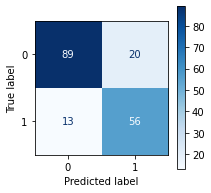

Accuracy XGBoost test 0.8146067415730337
Sensibility XGBoost test 0.8115942028985508
Specificity XGBoost test 0.8165137614678899


In [108]:
#XGBoost test
fig, ax = plt.subplots (figsize = (3, 3))
cm_xgb = metrics.confusion_matrix(y_test,preds_test_xg)
disp_xgb=ConfusionMatrixDisplay(cm_xgb,display_labels=[0,1])
disp_xgb = disp_xgb.plot(cmap=plt.cm.Blues,values_format='g', ax = ax)
plt.show()
print('Accuracy XGBoost test',metrics.accuracy_score(y_test,preds_test_xg))
print('Sensibility XGBoost test',metrics.recall_score( y_test,preds_test_xg,pos_label=1))
print('Specificity XGBoost test',metrics.recall_score( y_test,preds_test_xg,pos_label=0))

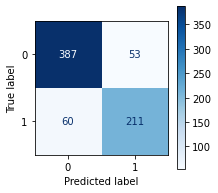

Accuracy XGBoost train 0.8410689170182841
Sensibility XGBoost train 0.7785977859778598
Specificity XGBoost train 0.8795454545454545


In [109]:
##XGboost train
fig, ax = plt.subplots (figsize = (3, 3))
cm_xgb = metrics.confusion_matrix(y_train,preds_train_xg)
disp_xgb=ConfusionMatrixDisplay(cm_xgb,display_labels=[0,1])
disp_xgb = disp_xgb.plot(cmap=plt.cm.Blues,values_format='g', ax = ax)
plt.show()
print('Accuracy XGBoost train',metrics.accuracy_score(y_train,preds_train_xg))
print('Sensibility XGBoost train',metrics.recall_score( y_train,preds_train_xg,pos_label=1))
print('Specificity XGBoost train',metrics.recall_score( y_train,preds_train_xg,pos_label=0))

<AxesSubplot:title={'center':'Importancia de variables: Modelo Titanic '}, xlabel='F score', ylabel='Features'>

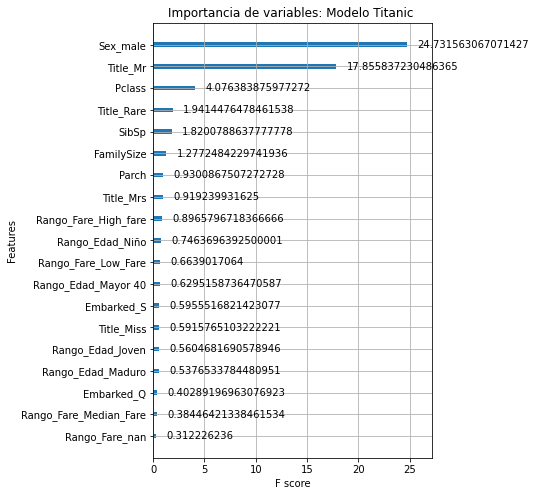

In [110]:
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(
            xgb1, 
            importance_type='gain',
            title='Importancia de variables: Modelo Titanic ',
            ax=ax)

In [442]:
test['Survived'] = (xgb1.predict_proba(x_test)[:,1] >= 0.5).astype(int)

In [443]:
test.head(2)

,PassengerId,Pclass,SibSp,Parch,FamilySize,Survived,Sex_female,Sex_male,Title_Master,Title_Miss,...,Rango_Edad_Joven,Rango_Edad_Maduro,Rango_Edad_Mayor 40,Embarked_C,Embarked_Q,Embarked_S,Rango_Fare_Low_Fare,Rango_Fare_Median_Fare,Rango_Fare_Average_Fare,Rango_Fare_High_fare
0,892,3,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,893,3,1,0,2,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [446]:
gender_submission = test.iloc[:, [0,5]]

In [447]:
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [448]:
gender_submission.to_csv('gender_submission_XG.csv',index=False)

#### Modelos

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 81.46
The cross validated score for Random Forest Classifier is: 83.24


Text(0.5, 1.05, 'Confusion_matrix Random Forest')

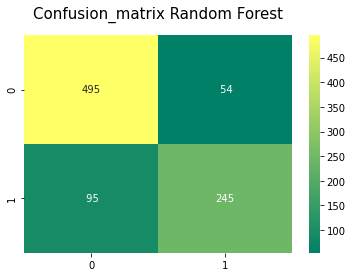

In [268]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix Random Forest', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the Support Vector Machines Classifier is 83.15
The cross validated score for Support Vector Machines Classifier is: 83.13


Text(0.5, 1.05, 'Confusion_matrix')

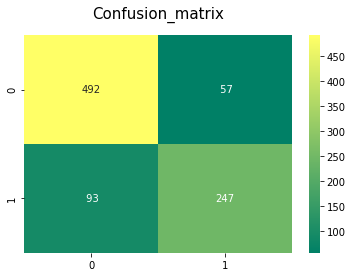

In [234]:
# Support Vector Machines
from sklearn.svm import SVC, LinearSVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Support Vector Machines Classifier is',round(accuracy_score(prediction_svm,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_svm=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for Support Vector Machines Classifier is:',round(result_svm.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 81.46
The cross validated score for Logistic REgression is: 82.23


Text(0.5, 1.05, 'Confusion_matrix')

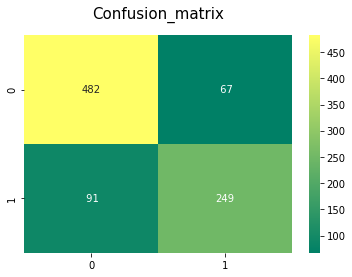

In [235]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Logistic Regression is',round(accuracy_score(prediction_lr,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_lr=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for Logistic REgression is:',round(result_lr.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier is 80.9
The cross validated score for K Nearest Neighbors Classifier is: 80.53


Text(0.5, 1.05, 'Confusion_matrix')

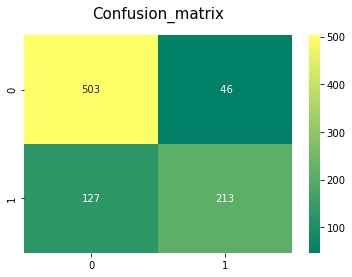

In [236]:
##knn
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22,shuffle = True) # k=10, split the data into 10 equal parts
result_knn=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the Gaussian Naive Bayes Classifier is 79.78
The cross validated score for Gaussian Naive Bayes classifier is: 79.86


Text(0.5, 1.05, 'Confusion_matrix')

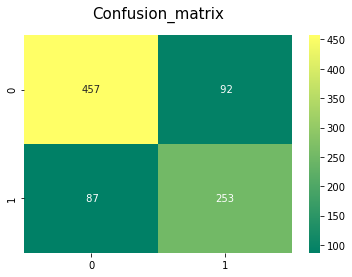

In [237]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model= GaussianNB()
model.fit(X_train,y_train)
prediction_gnb=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gaussian Naive Bayes Classifier is',round(accuracy_score(prediction_gnb,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_gnb=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for Gaussian Naive Bayes classifier is:',round(result_gnb.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the DecisionTree Classifier is 84.27
The cross validated score for Decision Tree classifier is: 81.44


Text(0.5, 1.05, 'Confusion_matrix')

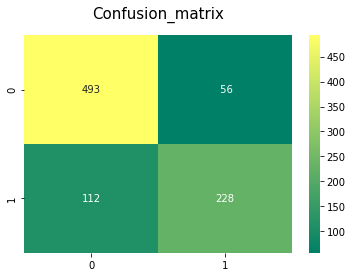

In [238]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier(criterion='gini', 
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto')
model.fit(X_train,y_train)
prediction_tree=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(prediction_tree,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_tree=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for Decision Tree classifier is:',round(result_tree.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the AdaBoostClassifier is 80.9
The cross validated score for AdaBoostClassifier is: 80.99


Text(0.5, 1.05, 'Confusion_matrix')

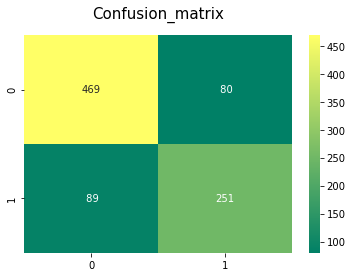

In [239]:
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_adb=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the AdaBoostClassifier is',round(accuracy_score(prediction_adb,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_adb=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_adb.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the LinearDiscriminantAnalysis is 80.9
The cross validated score for AdaBoostClassifier is: 82.46


Text(0.5, 1.05, 'Confusion_matrix')

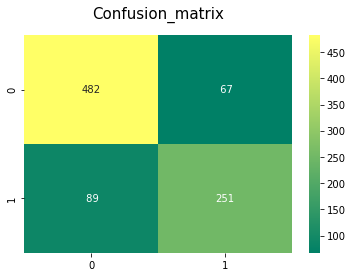

In [240]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model= LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
prediction_lda=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the LinearDiscriminantAnalysis is',round(accuracy_score(prediction_lda,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_lda=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_lda.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the Gradient Boosting Classifier is 83.15
The cross validated score for AdaBoostClassifier is: 82.45


Text(0.5, 1.05, 'Confusion_matrix')

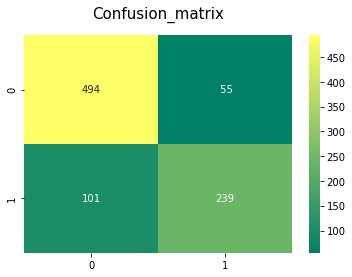

In [241]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(prediction_gbc,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle = True) # k=10, split the data into 10 equal parts
result_gbc=cross_val_score(model,x,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_gbc.mean()*100,2))
y_pred = cross_val_predict(model,x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

In [242]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Boosting', 'Linear Discriminant Analysis', 
              'Decision Tree'],
    'Score': [result_svm.mean(), result_knn.mean(), result_lr.mean(), 
              result_rm.mean(), result_gnb.mean(), result_adb.mean(), 
              result_gbc.mean(), result_lda.mean(), result_tree.mean()]})
models.sort_values(by='Score',ascending=False)

,Model,Score
3,Random Forest,0.832406
0,Support Vector Machines,0.831295
7,Linear Discriminant Analysis,0.824553
6,Gradient Boosting,0.824540
2,Logistic Regression,0.822280
8,Decision Tree,0.814428
5,AdaBoostClassifier,0.809934
1,KNN,0.805350
4,Naive Bayes,0.798634
